In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import json
import cv2
import os
import random
import numpy as np
from tqdm import tqdm
from pathlib import Path
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

def show_img(img, title=None):
    fig, ax = plt.subplots(nrows=1, ncols=1, dpi=150)
    ax.set_title( title, fontsize=16, color='black')
    ax.axes.xaxis.set_visible(False) # X軸を非表示に
    ax.axes.yaxis.set_visible(False) # Y軸を非表示に
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    return fig, ax


/home/dnn100/anaconda3/envs/diffusers/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def aspect_ratio(ox, oy):
    x, y = ox, oy
    while y:
        x, y = y, x % y
    return (ox/x, oy/x)

def calc_max_cropSize(img_shape:tuple, crop_aspect:tuple):
    img_height, img_width       = img_shape[:2]
    aspect_height, aspect_width = crop_aspect[:2]
    
    crop_height, crop_width = None, None

    # 切り取りサイズが同じの場合
    if aspect_height == aspect_width:
        crop_height = int(min(img_shape[:2]))
        crop_width  = int((min(img_shape[:2])/aspect_height)*aspect_width)

    # 切り取りサイズが縦長の場合
    elif aspect_height > aspect_width:
        crop_height = int(img_height)
        crop_width  = int((img_height/aspect_height)*aspect_width)

    # 切り取りサイズが横長の場合
    else:
        crop_width  = int(img_width)
        crop_height = int(img_width*(aspect_height/aspect_width))

    crop_shape = (crop_height, crop_width)
    center_pt = (int(img_width/2), int(img_height/2))

    return crop_shape, center_pt

def calc_crop_pt(center_pt:tuple, crop_shape:tuple):
    pt1 = (int(center_pt[0]-(crop_shape[1]/2)), int(center_pt[1]-(crop_shape[0]/2)))
    pt2 = (int(center_pt[0]+(crop_shape[1]/2)), int(center_pt[1]+(crop_shape[0]/2)))
    return (pt1, pt2)

def image_crop(img:np.ndarray, pt1, pt2):
    # check
    if (pt1[0] > pt2[0]) or (pt1[1] > pt2[1]):
        raise Exception("pt2 must be large value than pt1.")
    if pt1[0] < 0 or pt1[1] < 0:
        raise Exception("pt1 is invalid value.")
    if pt2[0] > img.shape[1] or pt2[1] > img.shape[0]:
        raise Exception("pt2 is invalid value.")

    return img[pt1[1]:pt2[1], pt1[0]:pt2[0]]


(<Figure size 960x720 with 1 Axes>, <Axes: >)

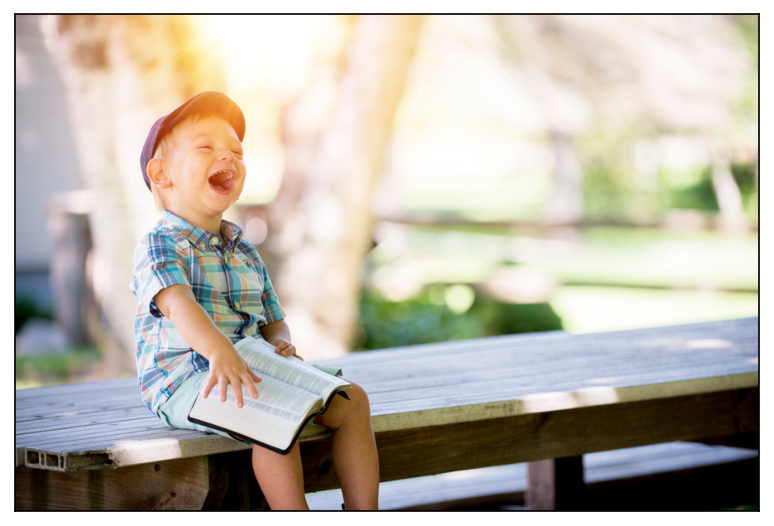

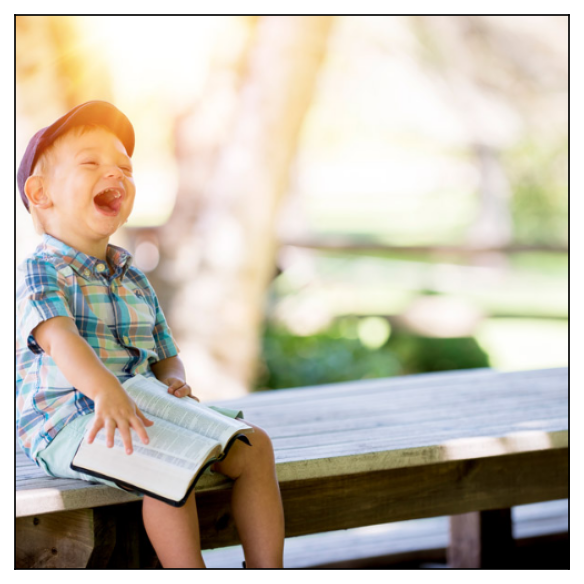

In [4]:
def frame_proc_func(frame:np.ndarray, crop_size:tuple):
    # 縦横比を保ったままクロップ
    # 指定されたcrop_sizeのアスペクト比の画像を元画像からクロップしてcrop_sizeの大きさにリサイズする

    crop_shape, center_pt = calc_max_cropSize(img_shape=frame.shape[:2], crop_aspect=aspect_ratio(*crop_size))
    pt1, pt2 = calc_crop_pt(center_pt, crop_shape)
    frame = image_crop(frame, pt1, pt2)

    frame = cv2.resize(frame, crop_size[::-1])

    return frame


sample_img_path = Path("../../sample_data/sample_jpg.jpg")
img = cv2.imread(str(sample_img_path))

show_img(img)
show_img(frame_proc_func(img, (500, 500)))



(<Figure size 960x720 with 1 Axes>, <Axes: >)

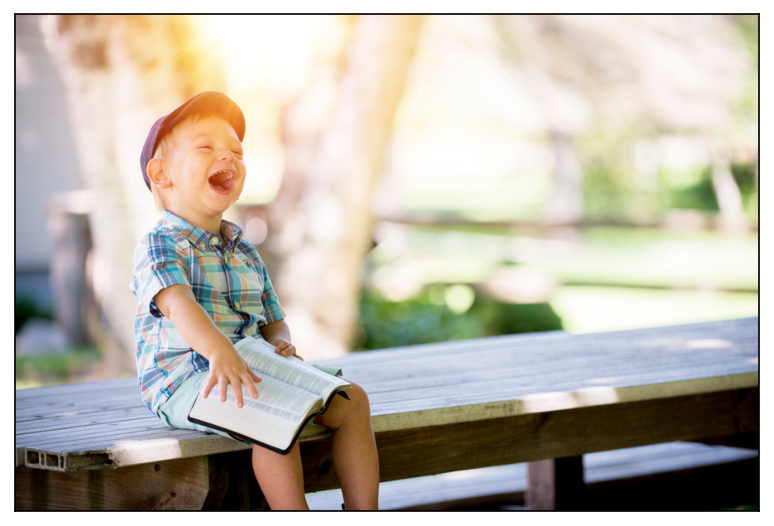

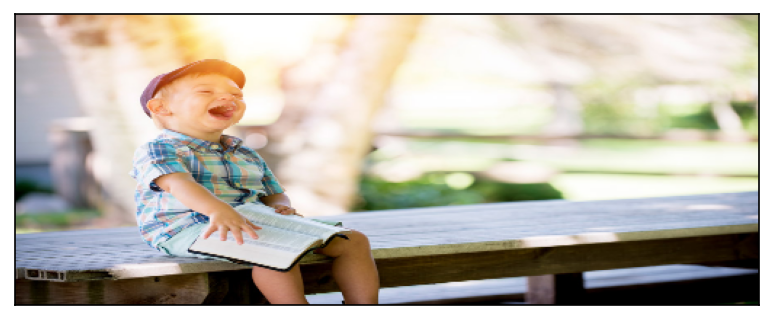

In [36]:
def frame_proc_func(frame:np.ndarray, crop_size:tuple):
    # 縦横比を保たずクロップ
    # crop_sizeの大きさにリサイズする
    frame = cv2.resize(frame, crop_size[::-1])

    return frame


sample_img_path = Path("../../sample_data/sample_jpg.jpg")
img = cv2.imread(str(sample_img_path))

show_img(img)
show_img(frame_proc_func(img, (200, 512)))

